## 注意力评分函数
上一节使⽤了⾼斯核来对查询和键之间的关系建模。(10.2.6)中的⾼斯核指数部分可以视为注意⼒评分函数
（attention scoring function），简称评分函数（scoring function），然后把这个函数的输出结果输⼊到softmax函
数中进⾏运算。通过上述步骤，将得到与键对应的值的概率分布（即注意⼒权重）。最后，注意⼒汇聚的输出
就是基于这些注意⼒权重的值的加权和。

从宏观来看，上述算法可以⽤来实现 图10.1.3中的注意⼒机制框架。图10.3.1说明了如何将注意⼒汇聚的输出
计算成为值的加权和，其中a表⽰注意⼒评分函数。由于注意⼒权重是概率分布，因此加权和其本质上是加
权平均值。

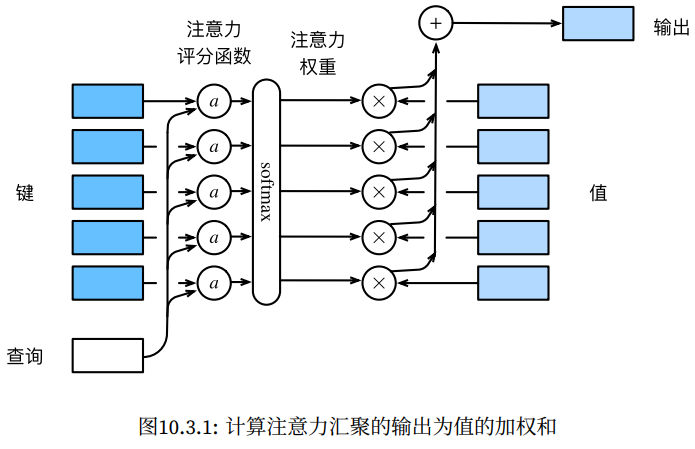

⽤数学语⾔描述，假设有⼀个查询 q ∈ Rq和 m个“键－值”对 (k1, v1), . . . ,(km, vm)，其中ki ∈ R
k，vi ∈ Rv。注意⼒汇聚函数f就被表⽰成值的加权和：  
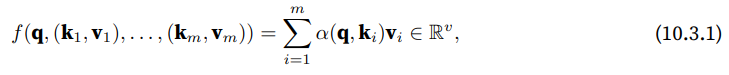  

其中查询q和键ki的注意⼒权重（标量）是通过注意⼒评分函数a将两个向量映射成标量，再经过softmax运
算得到的：
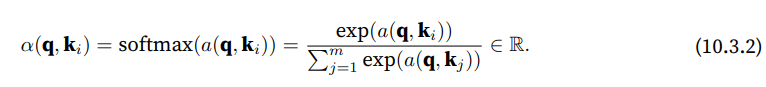  

正如上图所⽰，选择不同的注意⼒评分函数a会导致不同的注意⼒汇聚操作。本节将介绍两个流⾏的评分函
数，稍后将⽤他们来实现更复杂的注意⼒机制。



In [6]:
import math
import torch
from torch import nn
from d2l import torch as d2l

### 掩蔽softmax操作
正如上⾯提到的，softmax操作⽤于输出⼀个概率分布作为注意⼒权重。在某些情况下，并⾮所有的值都应该
被纳⼊到注意⼒汇聚中。例如，为了在 9.5节中⾼效处理⼩批量数据集，某些⽂本序列被填充了没有意义的
特殊词元。为了仅将有意义的词元作为值来获取注意⼒汇聚，可以指定⼀个有效序列⻓度（即词元的个数），
以便在计算softmax时过滤掉超出指定范围的位置。下⾯的masked_softmax函数实现了这样的掩蔽softmax操
作（masked softmax operation），其中任何超出有效⻓度的位置都被掩蔽并置为0。

In [7]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后⼀个轴上掩蔽元素来执⾏softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后⼀轴上被掩蔽的元素使⽤⼀个⾮常⼤的负值替换，从⽽其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                            value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)


为了演⽰此函数是如何⼯作的，考虑由两个2 × 4矩阵表⽰的样本，这两个样本的有效⻓度分别为2和3。经过
掩蔽softmax操作，超出有效⻓度的值都被掩蔽为0。


In [8]:
# dim=-1表示对每一行相加=1
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4923, 0.5077, 0.0000, 0.0000],
         [0.5191, 0.4809, 0.0000, 0.0000]],

        [[0.3974, 0.3610, 0.2416, 0.0000],
         [0.3488, 0.3215, 0.3296, 0.0000]]])

同样，也可以使⽤⼆维张量，为矩阵样本中的每⼀⾏指定有效⻓度。

In [9]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4473, 0.2960, 0.2567, 0.0000]],

        [[0.6094, 0.3906, 0.0000, 0.0000],
         [0.2141, 0.2765, 0.3443, 0.1651]]])

### 加性注意力
⼀般来说，当查询和键是不同⻓度的⽮量时，可以使⽤加性注意⼒作为评分函数。给定查询q ∈ R
q和键k ∈ Rk，加性注意⼒（additive attention）的评分函数为  
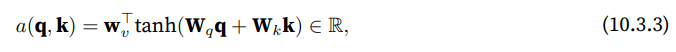  

其中可学习的参数是Wq ∈ Rh×q、Wk ∈ Rh×k和 wv ∈ Rh。如 (10.3.3)所⽰，将查询和键连结起来后输⼊到⼀
个多层感知机（MLP）中，感知机包含⼀个隐藏层，其隐藏单元数是⼀个超参数h。通过使⽤tanh作为激活函数，并且禁⽤偏置项。  

下⾯来实现加性注意⼒。


In [1]:
#@save
class AdditiveAttention(nn.Module):
    """加性注意⼒"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使⽤⼴播⽅式进⾏求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有⼀个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)


NameError: name 'save' is not defined

⽤⼀个⼩例⼦来演⽰上⾯的AdditiveAttention类，其中查询、键和值的形状为（批量⼤⼩，步数或词元序列
⻓度，特征⼤⼩），实际输出为(2, 1, 20)、(2, 10, 2)和(2, 10, 4)。注意⼒汇聚输出的形状为（批量⼤⼩，查询的
步数，值的维度）。

In [15]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
print("queries:",queries)
print("keys:",keys)
# values的⼩批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
print("values:",values)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
    dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)


queries: tensor([[[-0.5750, -0.6622, -1.2842, -0.4675, -1.0729, -1.7332,  1.0119,
          -0.9756, -0.8412,  0.4551,  0.7161,  0.6222,  0.5495,  0.6174,
           0.1252,  3.1434, -0.1029,  1.6773, -0.3569, -1.4736]],

        [[ 0.6871, -1.3941, -0.6511, -1.6743,  1.0740,  2.1422, -0.0392,
          -0.7432,  0.2081,  2.3039, -0.0756, -0.7793, -0.5652,  0.6075,
          -1.4353,  1.7135,  0.2482, -0.5605, -0.4352, -0.1269]]])
keys: tensor([[[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]])
values tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20.

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

尽管加性注意⼒包含了可学习的参数，但由于本例⼦中每个键都是相同的，所以注意⼒权重是均匀的，由指
定的有效⻓度决定。  
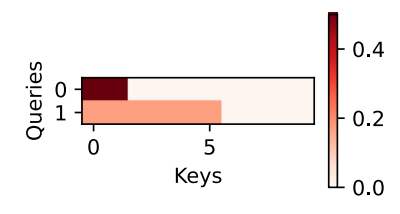

### 缩放点积注意力
使⽤点积可以得到计算效率更⾼的评分函数，但是点积操作要求查询和键具有相同的⻓度d。假设查询和键
的所有元素都是独⽴的随机变量，并且都满⾜零均值和单位⽅差，那么两个向量的点积的均值为0，⽅差为d。
为确保⽆论向量⻓度如何，点积的⽅差在不考虑向量⻓度的情况下仍然是1，我们再将点积除以√
d，则缩放点积注意⼒（scaled dot-product attention）评分函数为：  
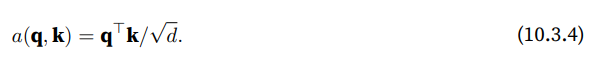  

在实践中，我们通常从⼩批量的⻆度来考虑提⾼效率，例如基于n个查询和m个键－值对计算注意⼒，其中查
询和键的⻓度为d，值的⻓度为v。查询Q ∈ Rn×d、键K ∈ Rm×d和值V ∈ Rm×v的缩放点积注意⼒是：  
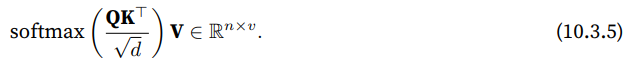  

下⾯的缩放点积注意⼒的实现使⽤了暂退法进⾏模型正则化。


In [12]:
#@save
class DotProductAttention(nn.Module):
    """缩放点积注意⼒"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)


为了演⽰上述的DotProductAttention类，我们使⽤与先前加性注意⼒例⼦中相同的键、值和有效⻓度。对于
点积操作，我们令查询的特征维度与键的特征维度⼤⼩相同。


In [13]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

与加性注意⼒演⽰相同，由于键包含的是相同的元素，⽽这些元素⽆法通过任何查询进⾏区分，因此获得了
均匀的注意⼒权重。  
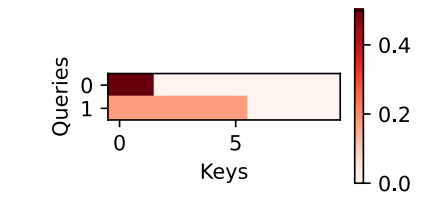

## 小结
* 将注意⼒汇聚的输出计算可以作为值的加权平均，选择不同的注意⼒评分函数会带来不同的注意⼒汇聚操作。
* 当查询和键是不同⻓度的⽮量时，可以使⽤可加性注意⼒评分函数。当它们的⻓度相同时，使⽤缩放的“点－积”注意⼒评分函数的计算效率更⾼。

